# NeMA-Lite — Sweep Results Summary (Paper 1)

This notebook summarises the sweep experiments for **NeMA-Lite**:

- **Model:** Transformer encoder + external memory + learned write gate
- **Task:** Synthetic delayed-QA (predict a digit from early in the sequence)
- **Swept hyperparameters:**
  - `mem_lambda` — memory budget penalty strength
  - `write_threshold` — threshold for hard write decisions

## Outputs produced by this notebook
- **Table 1 CSV:** `../tables/summary_final_epoch.csv`
- Quick diagnostics (how many runs/rows were loaded)
- Best configuration(s) by validation accuracy
- Your saved plots displayed inside the notebook
- Optional: a per-configuration “Memory ON vs OFF” curve (more informative than averaging over all configs)



In [1]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt

# Notebook-relative paths
RESULTS_DIR = "../results"
PLOTS_DIR   = "../plots"
TABLES_DIR  = "../tables"

os.makedirs(TABLES_DIR, exist_ok=True)

print("Current working directory:", os.getcwd())
print("RESULTS_DIR:", os.path.abspath(RESULTS_DIR))
print("PLOTS_DIR:", os.path.abspath(PLOTS_DIR))
print("TABLES_DIR:", os.path.abspath(TABLES_DIR))

csv_files = glob.glob(os.path.join(RESULTS_DIR, "*.csv"))
print("Found CSV files:", len(csv_files))
csv_files[:5]

Current working directory: /workspaces/NeMA-paper-1/nema-paper1/notebooks
RESULTS_DIR: /workspaces/NeMA-paper-1/nema-paper1/results
PLOTS_DIR: /workspaces/NeMA-paper-1/nema-paper1/plots
TABLES_DIR: /workspaces/NeMA-paper-1/nema-paper1/tables
Found CSV files: 37


['../results/ml0.1_wt0.7_s2_a832dbe8.csv',
 '../results/ml0.0_wt0.3_s2_bbfdd01b.csv',
 '../results/ml0.05_wt0.5_s2_cb9f825f.csv',
 '../results/ml0.05_wt0.3_s2_f4d4b41c.csv',
 '../results/ml0.2_wt0.3_s2_56fe793b.csv']

## 1) Load all sweep logs

Each sweep run writes one CSV with per-epoch metrics (e.g., `epoch`, `val_acc_mem`, `avg_write_ratio`).

We load all CSVs into one dataframe called `all_df`.

In [2]:
assert len(csv_files) > 0, (
    f"No CSV files found in {RESULTS_DIR}. "
    "Make sure your sweep wrote into nema-paper1/results/."
)

dfs = []
for f in csv_files:
    df = pd.read_csv(f)
    df["_source_file"] = os.path.basename(f)  # keep provenance
    dfs.append(df)

all_df = pd.concat(dfs, ignore_index=True)

print("Merged rows:", len(all_df))
print("Unique run_ids:", all_df["run_id"].nunique())
all_df.head()

Merged rows: 730
Unique run_ids: 37


,run_id,epoch,mem_lambda,write_threshold,avg_write_ratio,train_loss,val_loss_mem,val_acc_mem,val_loss_nomem,val_acc_nomem,_source_file
0,ml0.1_wt0.7_s2_a832dbe8,1,0.1,0.7,0.000053,2.339216,2.309400,0.105,2.309400,0.105,ml0.1_wt0.7_s2_a832dbe8.csv
1,ml0.1_wt0.7_s2_a832dbe8,2,0.1,0.7,0.000000,2.283562,2.336998,0.112,2.336998,0.112,ml0.1_wt0.7_s2_a832dbe8.csv
2,ml0.1_wt0.7_s2_a832dbe8,3,0.1,0.7,0.000000,2.256148,2.252212,0.160,2.252212,0.160,ml0.1_wt0.7_s2_a832dbe8.csv
3,ml0.1_wt0.7_s2_a832dbe8,4,0.1,0.7,0.000000,2.234710,2.256939,0.152,2.256939,0.152,ml0.1_wt0.7_s2_a832dbe8.csv
4,ml0.1_wt0.7_s2_a832dbe8,5,0.1,0.7,0.000000,2.211422,2.271988,0.154,2.271988,0.154,ml0.1_wt0.7_s2_a832dbe8.csv


## 2) Validate required columns and coerce numeric types

We enforce expected columns and convert numeric fields safely.
This prevents subtle plotting/aggregation bugs.

In [3]:
required_cols = [
    "run_id", "epoch", "mem_lambda", "write_threshold",
    "avg_write_ratio", "val_acc_mem", "val_acc_nomem"
]
missing = [c for c in required_cols if c not in all_df.columns]
assert not missing, f"Missing required columns: {missing}"

# Convert numeric columns
numeric_cols = ["epoch", "mem_lambda", "write_threshold", "avg_write_ratio", "val_acc_mem", "val_acc_nomem"]
for c in numeric_cols:
    all_df[c] = pd.to_numeric(all_df[c], errors="coerce")

# Drop rows that are missing critical values
before = len(all_df)
all_df = all_df.dropna(subset=["run_id", "epoch", "mem_lambda", "write_threshold"])
after = len(all_df)
print(f"Dropped {before-after} rows with missing critical fields")

all_df.describe().T[["count", "mean", "std", "min", "max"]]

Dropped 0 rows with missing critical fields


,count,mean,std,min,max
epoch,730.0,10.431507,5.769828,1.000000,20.000000
mem_lambda,730.0,0.087671,0.073507,0.000000,0.200000
write_threshold,730.0,0.500000,0.162288,0.300000,0.700000
avg_write_ratio,730.0,0.126563,0.307844,0.000000,1.000000
train_loss,730.0,2.091168,0.152538,1.748353,2.387785
val_loss_mem,730.0,2.354029,0.088737,2.216783,2.647424
val_acc_mem,730.0,0.155111,0.015331,0.087000,0.188000
val_loss_nomem,730.0,2.336917,0.088906,2.208598,2.647424
val_acc_nomem,730.0,0.156362,0.015003,0.087000,0.192000


## 3) Extract final epoch per run

For Paper 1, we summarise each run by its **final epoch** metrics, then aggregate across runs/seeds.

In [4]:
final_df = all_df.sort_values("epoch").groupby("run_id").tail(1)

print("Final-epoch rows:", len(final_df))
final_df[["run_id", "mem_lambda", "write_threshold", "avg_write_ratio", "val_acc_mem", "val_acc_nomem"]].head(10)

Final-epoch rows: 37


,run_id,mem_lambda,write_threshold,avg_write_ratio,val_acc_mem,val_acc_nomem
549,run_20251211_155859,0.10,0.5,0.000000,0.167,0.167
399,ml0.2_wt0.5_s0_5ab13333,0.20,0.5,0.000000,0.162,0.162
419,ml0.2_wt0.3_s0_adaf2101,0.20,0.3,0.000000,0.147,0.147
649,ml0.05_wt0.7_s0_ff5c12e4,0.05,0.7,0.000000,0.145,0.145
159,ml0.0_wt0.5_s0_08accc43,0.00,0.5,0.187159,0.160,0.159
139,ml0.1_wt0.5_s1_d1d9656a,0.10,0.5,0.000000,0.145,0.145
629,ml0.1_wt0.3_s2_bb0443df,0.10,0.3,0.000000,0.167,0.167
539,ml0.2_wt0.7_s1_e3dc12fc,0.20,0.7,0.000000,0.154,0.154
519,ml0.05_wt0.5_s0_68443a62,0.05,0.5,0.000000,0.157,0.157
589,ml0.0_wt0.7_s1_d9a505e7,0.00,0.7,0.000000,0.166,0.166


## 4) Table 1 — Final epoch summary (mean ± std)

We group by `(mem_lambda, write_threshold)` and compute:

- mean ± std of `avg_write_ratio`
- mean ± std of `val_acc_mem` and `val_acc_nomem`

Then we save:
- `../tables/summary_final_epoch.csv`


In [5]:
summary = final_df.groupby(["mem_lambda", "write_threshold"]).agg(
    runs=("run_id", "count"),
    write_ratio_mean=("avg_write_ratio", "mean"),
    write_ratio_std=("avg_write_ratio", "std"),
    acc_mem_mean=("val_acc_mem", "mean"),
    acc_mem_std=("val_acc_mem", "std"),
    acc_nomem_mean=("val_acc_nomem", "mean"),
    acc_nomem_std=("val_acc_nomem", "std"),
).reset_index().sort_values(["mem_lambda", "write_threshold"])

out_path = os.path.join(TABLES_DIR, "summary_final_epoch.csv")
summary.to_csv(out_path, index=False)

print("Saved Table 1 CSV to:", out_path)
summary


Saved Table 1 CSV to: ../tables/summary_final_epoch.csv


,mem_lambda,write_threshold,runs,write_ratio_mean,write_ratio_std,acc_mem_mean,acc_mem_std,acc_nomem_mean,acc_nomem_std
0,0.00,0.3,3,0.999999,0.000002,0.143333,0.007767,0.145000,0.006557
1,0.00,0.5,3,0.466055,0.346420,0.161000,0.004583,0.157000,0.003464
2,0.00,0.7,3,0.000001,0.000002,0.158333,0.007095,0.158333,0.007095
3,0.05,0.3,3,0.000000,0.000000,0.163667,0.012897,0.163667,0.012897
4,0.05,0.5,3,0.000000,0.000000,0.154000,0.012767,0.154000,0.012767
5,0.05,0.7,3,0.000000,0.000000,0.152333,0.006429,0.152333,0.006429
6,0.10,0.3,3,0.000000,0.000000,0.157667,0.008145,0.157667,0.008145
7,0.10,0.5,4,0.000000,0.000000,0.144500,0.017991,0.144500,0.017991
8,0.10,0.7,3,0.000000,0.000000,0.157667,0.004726,0.157667,0.004726
9,0.20,0.3,3,0.000000,0.000000,0.149667,0.005508,0.149667,0.005508


## 5) Best configurations (by accuracy with memory)

We list the top configurations sorted by `acc_mem_mean`.

These are the candidates for:
- “best config” reporting
- focused per-config plots
- extra seed runs (optional)

In [6]:
best_cfgs = summary.sort_values("acc_mem_mean", ascending=False).head(10)
best_cfgs

,mem_lambda,write_threshold,runs,write_ratio_mean,write_ratio_std,acc_mem_mean,acc_mem_std,acc_nomem_mean,acc_nomem_std
3,0.05,0.3,3,0.000000,0.000000,0.163667,0.012897,0.163667,0.012897
1,0.00,0.5,3,0.466055,0.346420,0.161000,0.004583,0.157000,0.003464
11,0.20,0.7,3,0.000000,0.000000,0.159667,0.008145,0.159667,0.008145
2,0.00,0.7,3,0.000001,0.000002,0.158333,0.007095,0.158333,0.007095
8,0.10,0.7,3,0.000000,0.000000,0.157667,0.004726,0.157667,0.004726
6,0.10,0.3,3,0.000000,0.000000,0.157667,0.008145,0.157667,0.008145
4,0.05,0.5,3,0.000000,0.000000,0.154000,0.012767,0.154000,0.012767
10,0.20,0.5,3,0.000000,0.000000,0.153667,0.010408,0.153667,0.010408
5,0.05,0.7,3,0.000000,0.000000,0.152333,0.006429,0.152333,0.006429
9,0.20,0.3,3,0.000000,0.000000,0.149667,0.005508,0.149667,0.005508


## 6) Display saved plots

This reads your PNG plots from `../plots/` and displays them here.

Showing: acc_vs_write_ratio.png


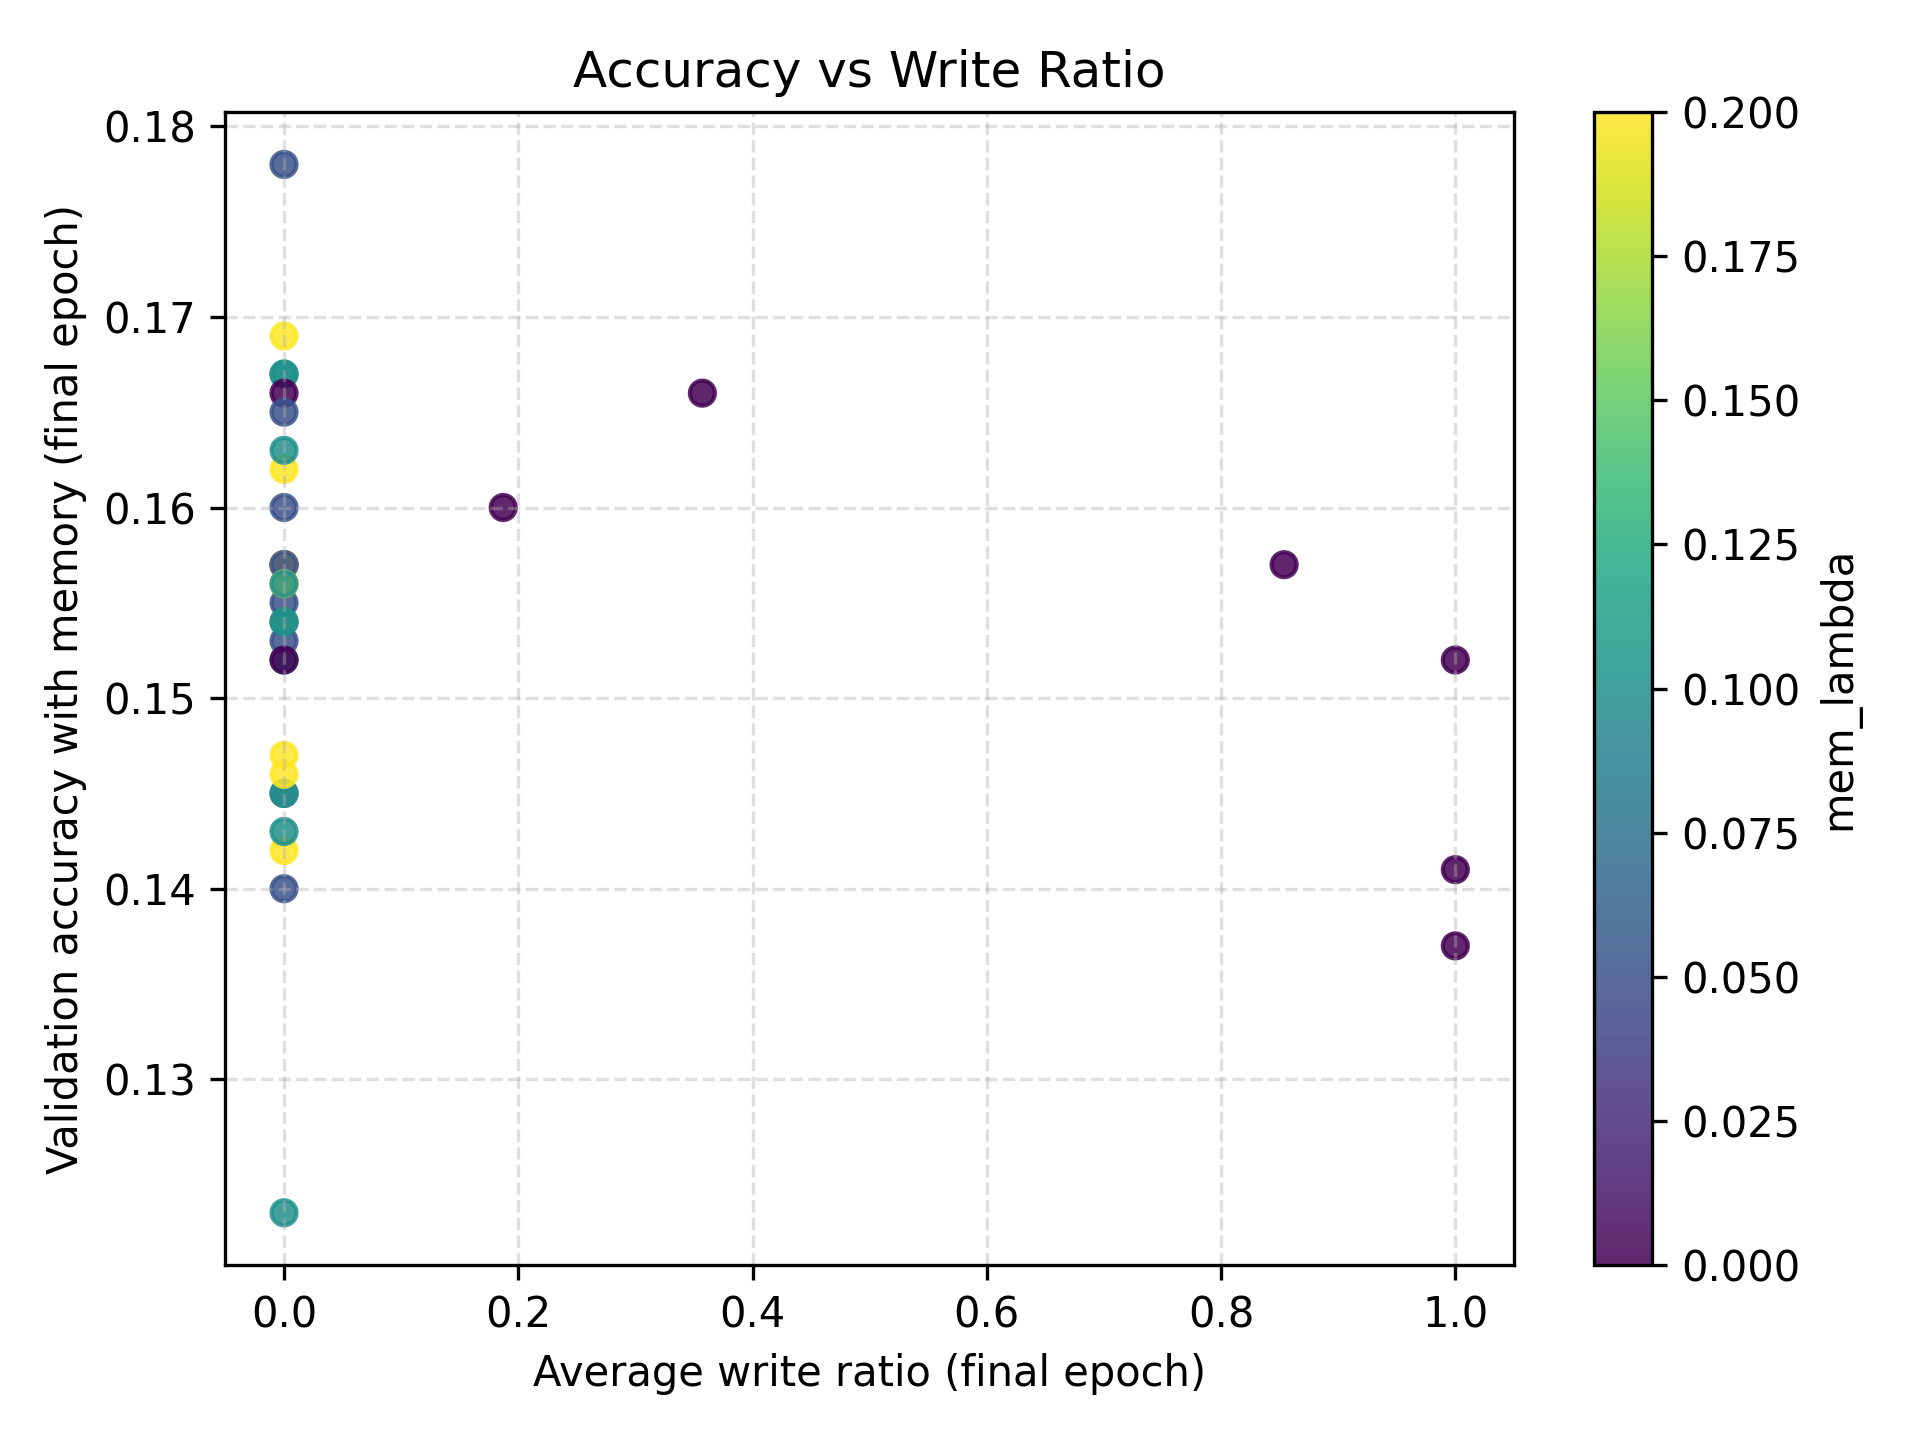

Showing: memory_on_vs_off.png


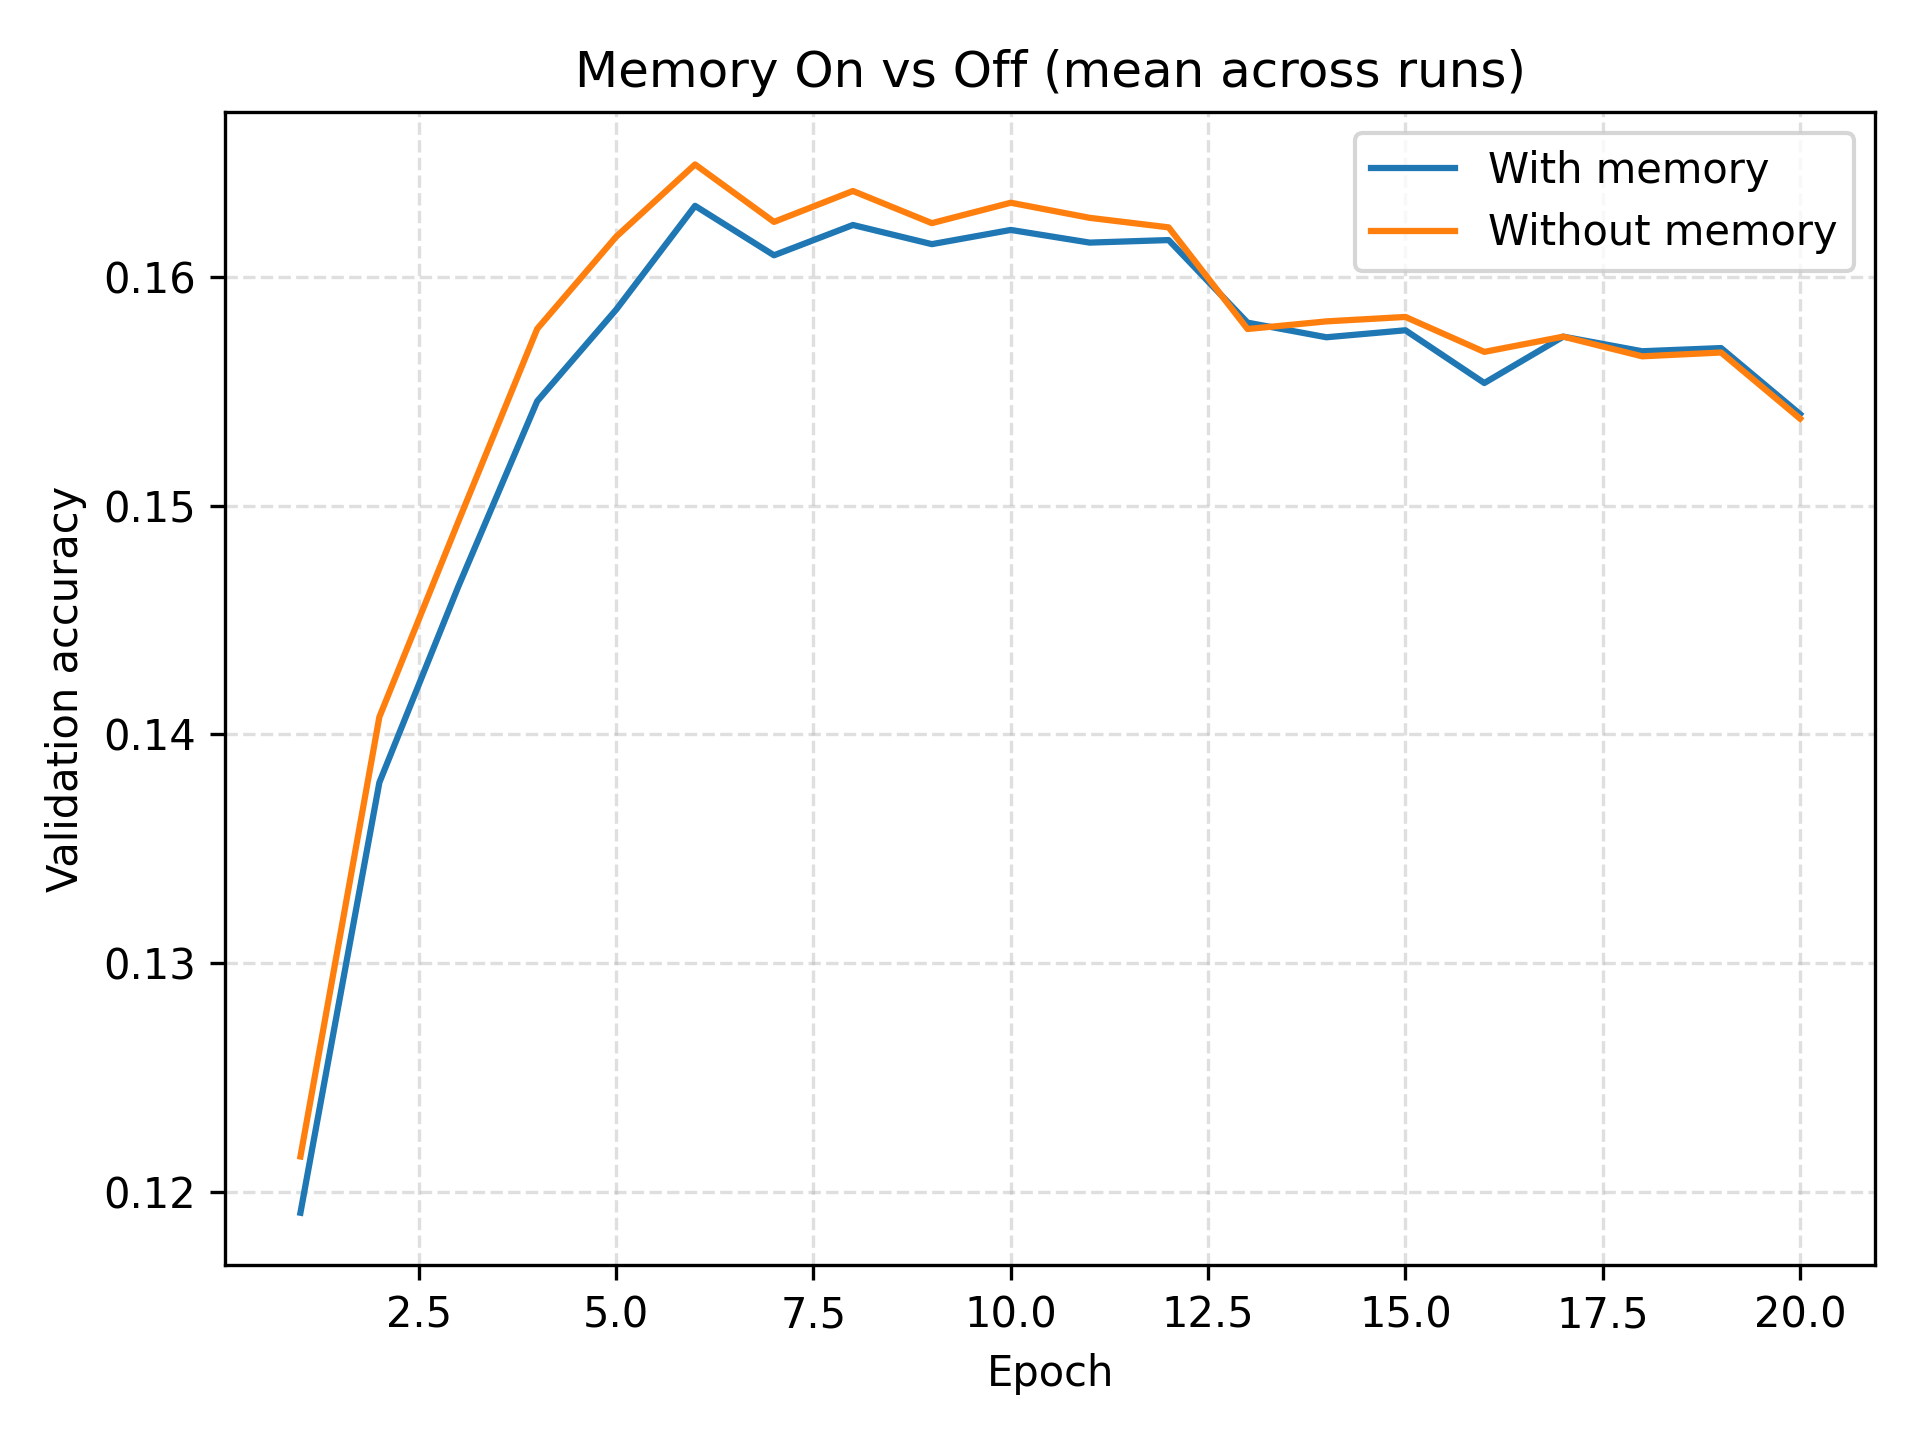

Showing: write_ratio_vs_mem_lambda.png


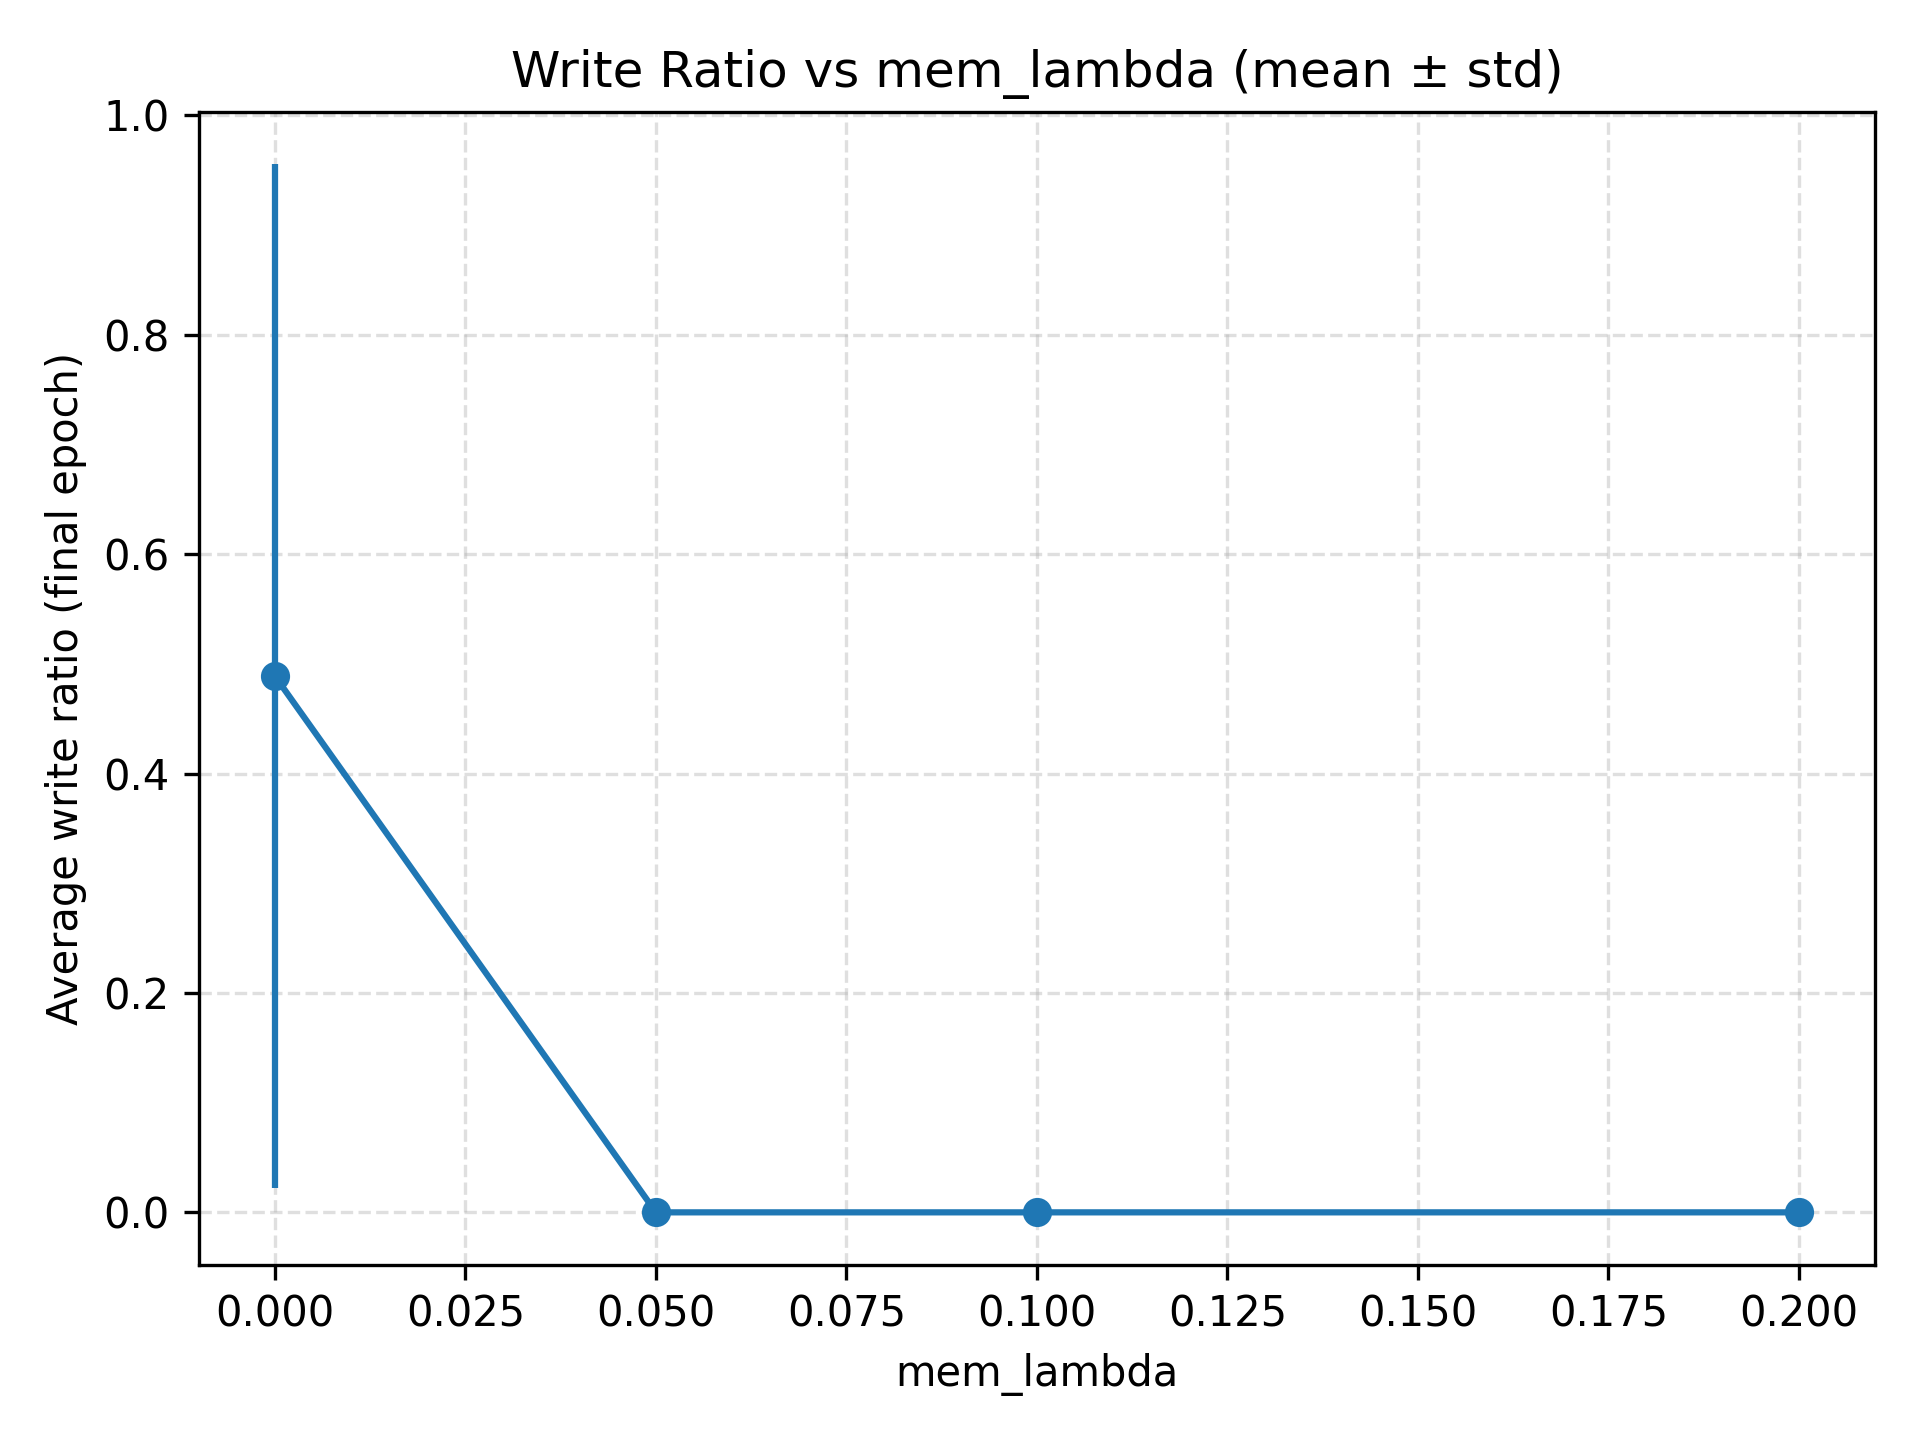

Showing: acc_vs_mem_lambda.png


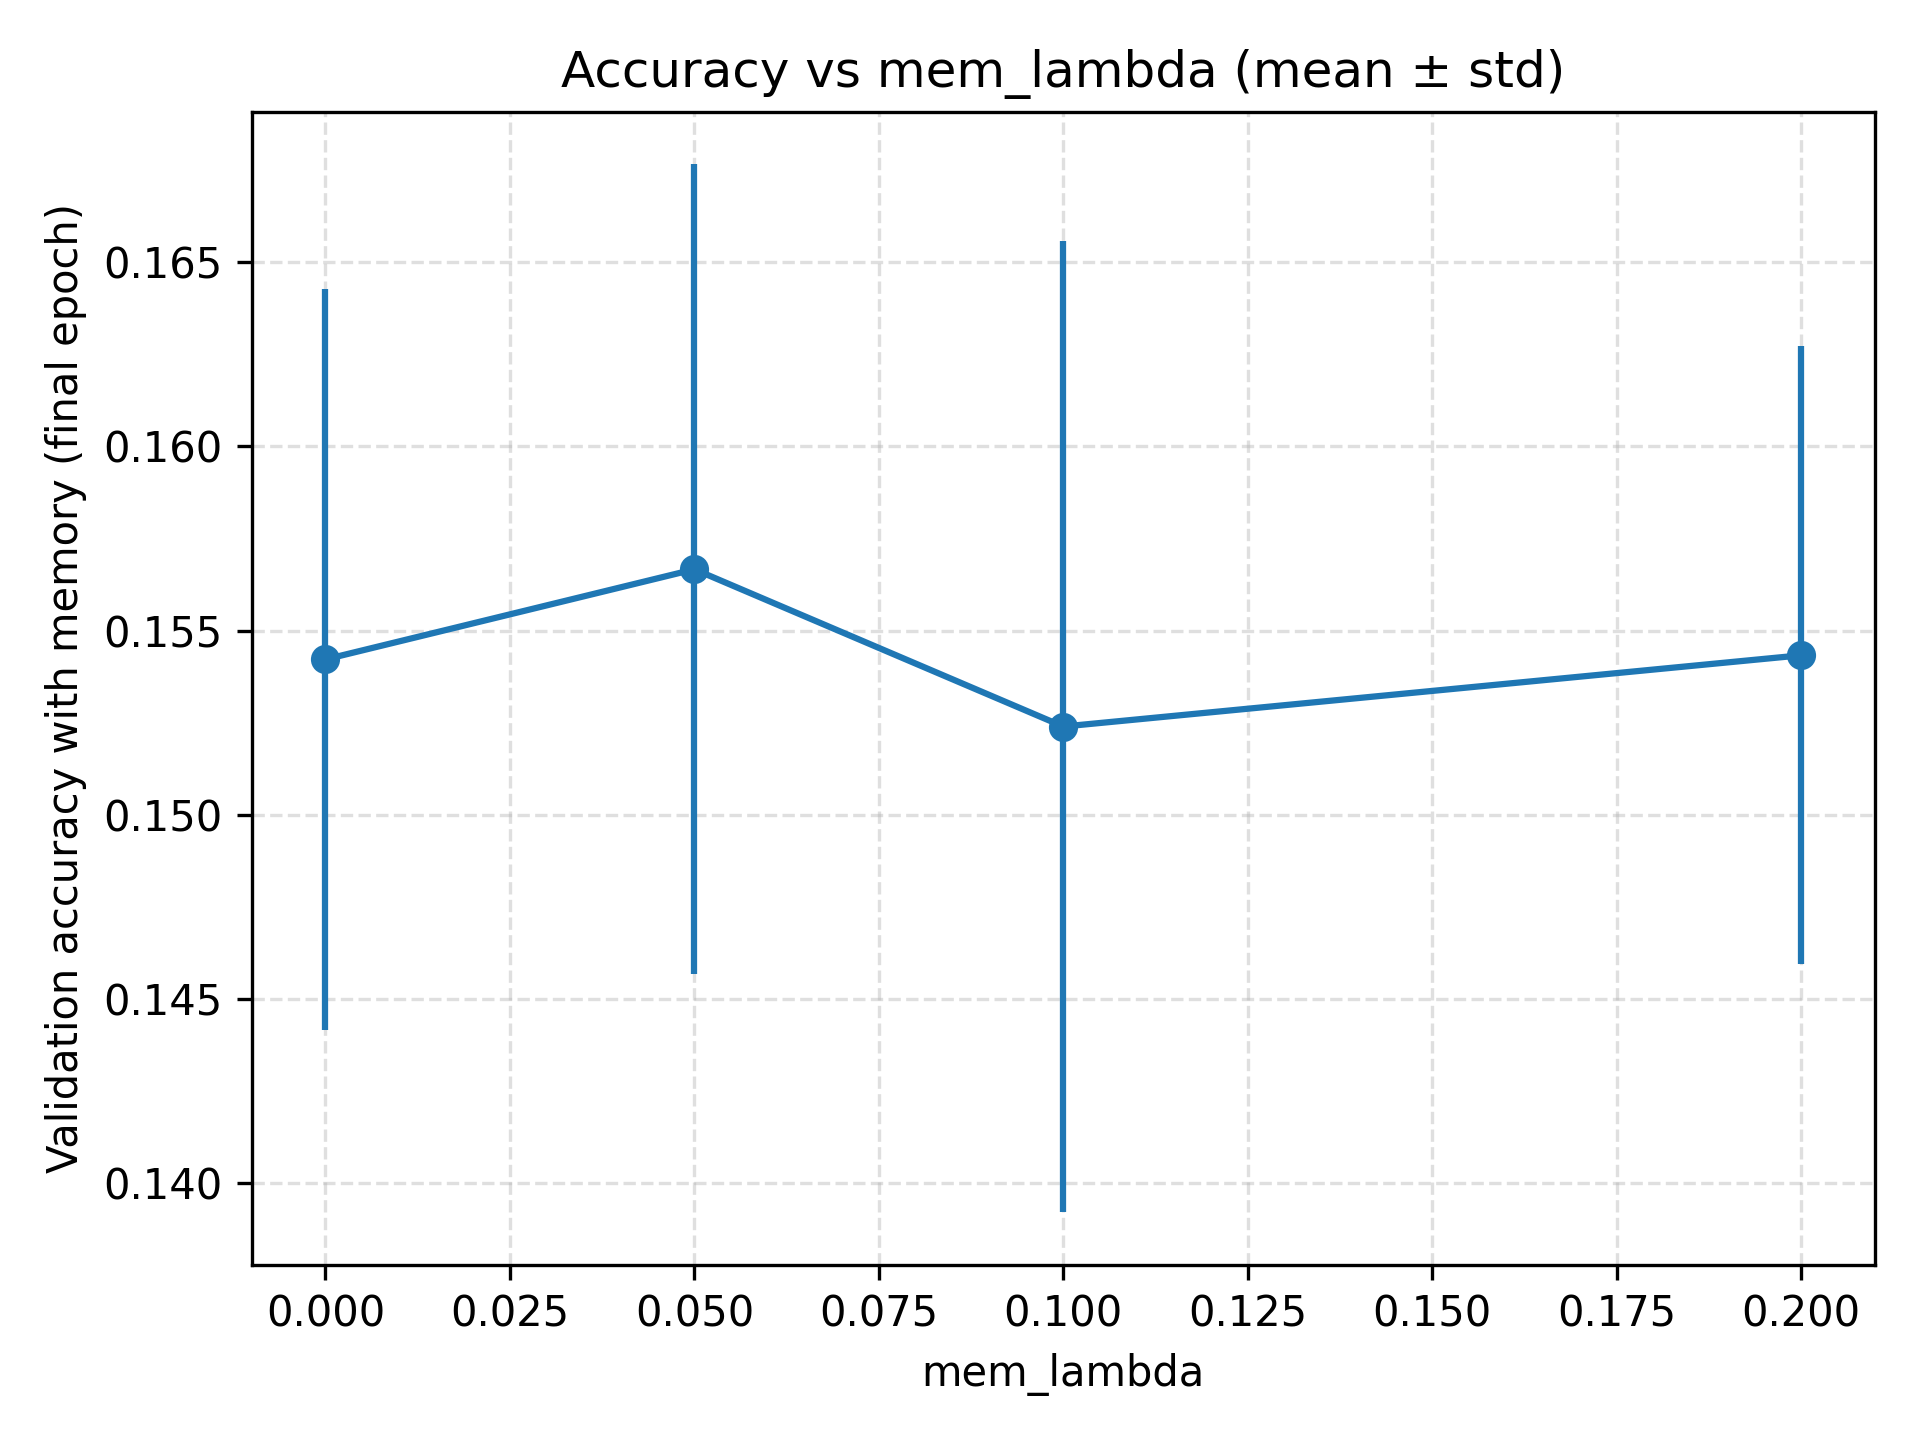

Showing: tradeoff_by_threshold.png


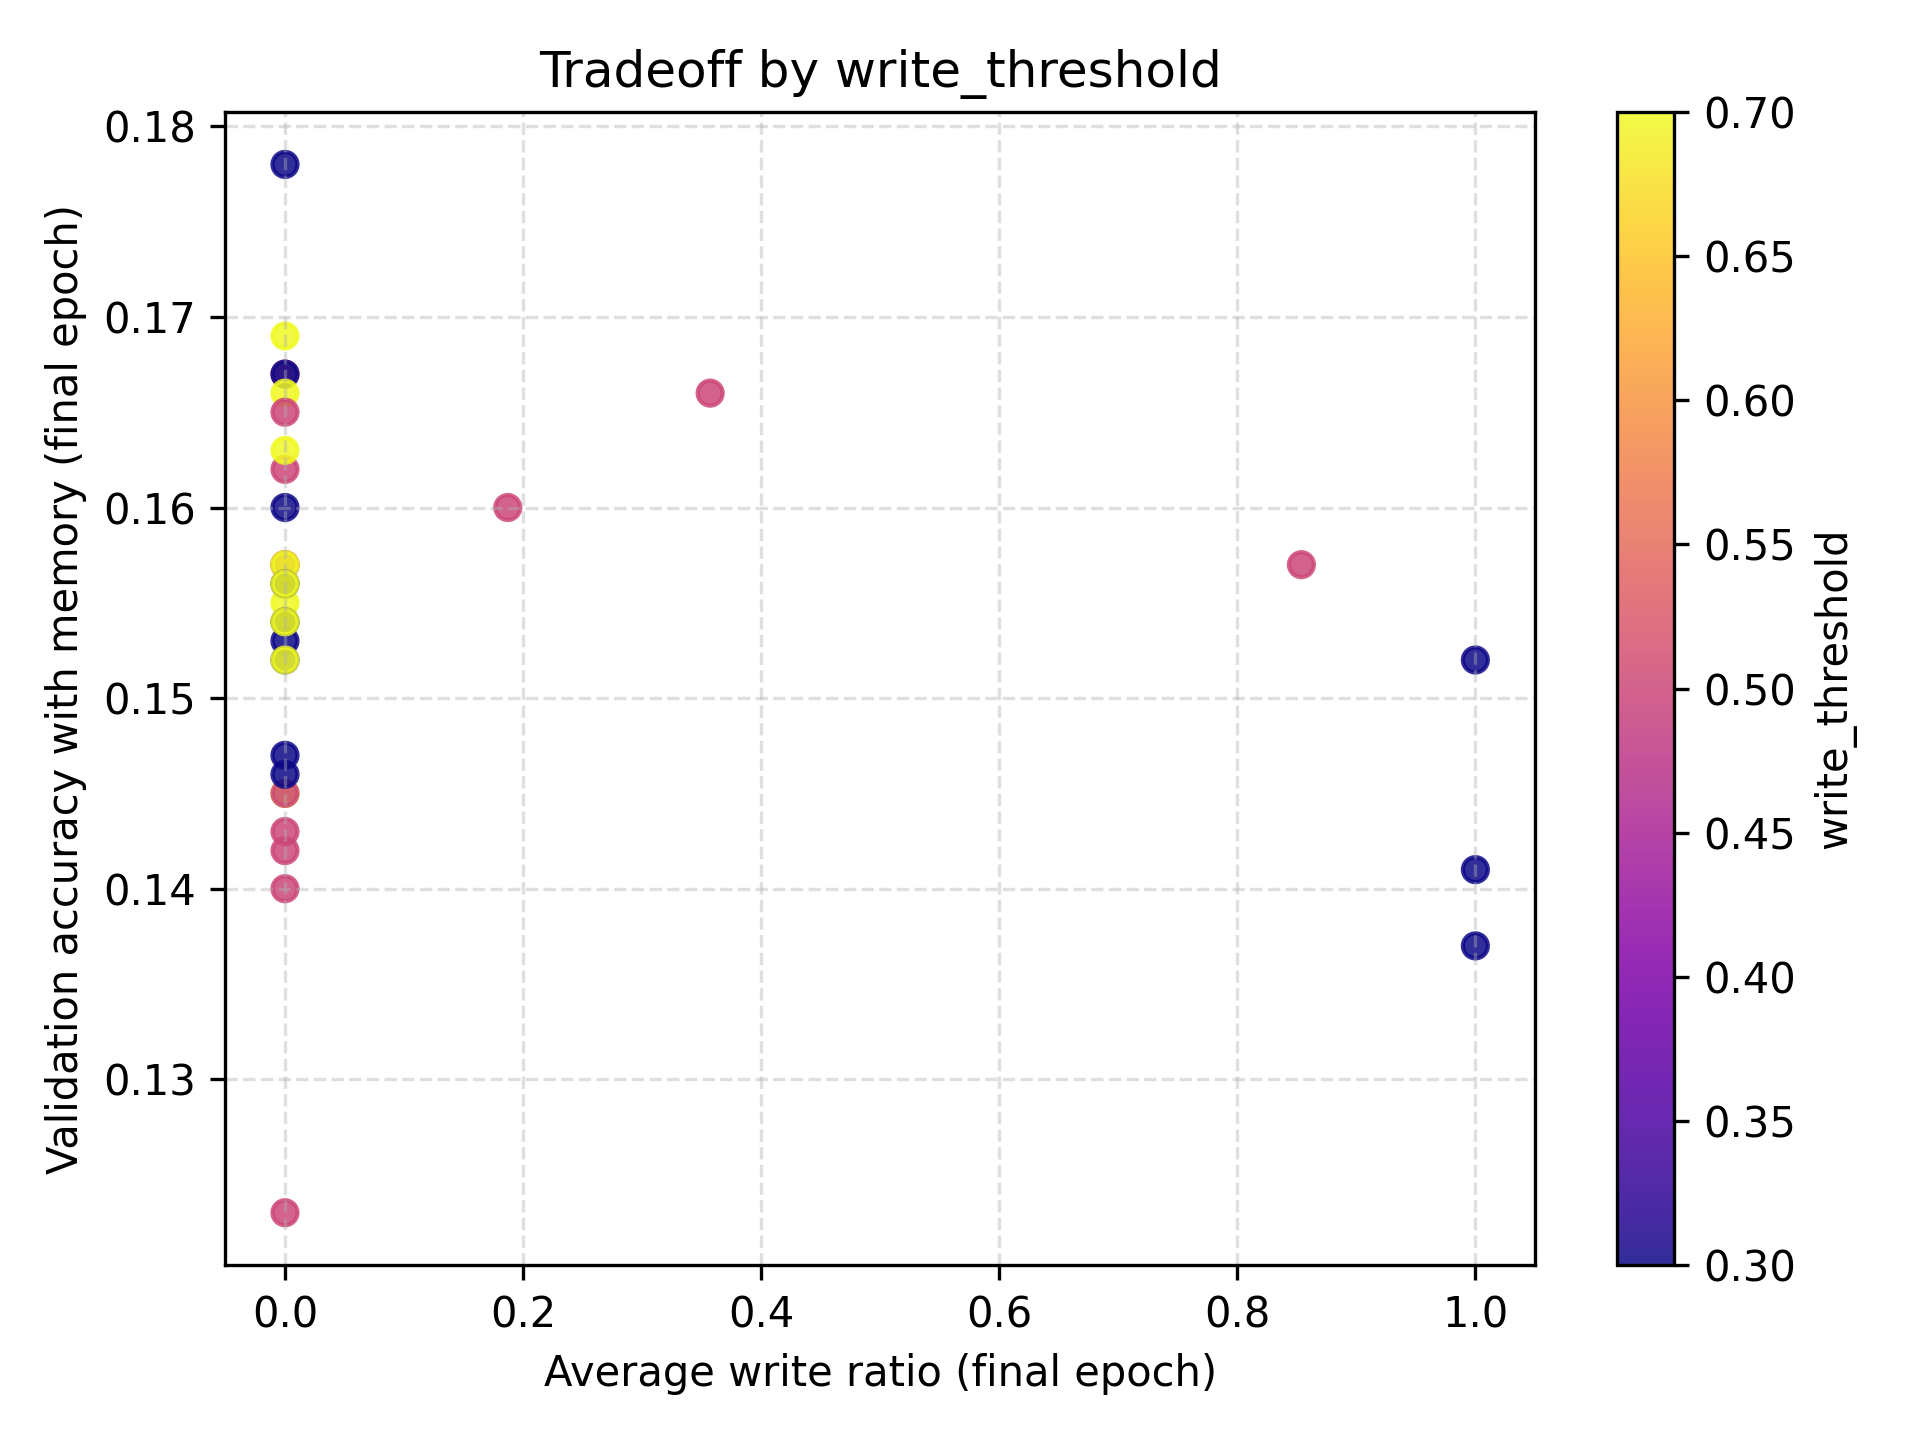

In [7]:
from PIL import Image
from IPython.display import display

plot_files = [
    "acc_vs_write_ratio.png",
    "memory_on_vs_off.png",
    "write_ratio_vs_mem_lambda.png",
    "acc_vs_mem_lambda.png",
    "tradeoff_by_threshold.png",
]

for p in plot_files:
    path = os.path.join(PLOTS_DIR, p)
    if os.path.exists(path):
        print("Showing:", p)
        display(Image.open(path))
    else:
        print("Missing:", path)

## 7) Per-configuration “Memory ON vs OFF” curve (recommended)

The existing `memory_on_vs_off.png` averages across **all runs/configs** which can hide real effects.

Here we plot memory ON vs OFF for a **single configuration**, typically the best one.

Selected config: mem_lambda=0.05, write_threshold=0.3
Runs in this config: 3


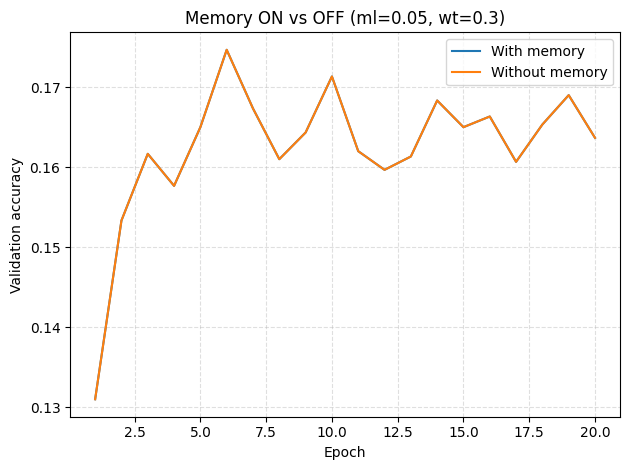

In [8]:
# Pick the best configuration automatically (top row of best_cfgs)
ml = float(best_cfgs.iloc[0]["mem_lambda"])
wt = float(best_cfgs.iloc[0]["write_threshold"])

df_cfg = all_df[(all_df["mem_lambda"] == ml) & (all_df["write_threshold"] == wt)].copy()

print(f"Selected config: mem_lambda={ml}, write_threshold={wt}")
print("Runs in this config:", df_cfg["run_id"].nunique())

curve = df_cfg.groupby("epoch").agg(
    acc_mem=("val_acc_mem", "mean"),
    acc_nomem=("val_acc_nomem", "mean"),
).reset_index()

plt.figure()
plt.plot(curve["epoch"], curve["acc_mem"], label="With memory")
plt.plot(curve["epoch"], curve["acc_nomem"], label="Without memory")
plt.title(f"Memory ON vs OFF (ml={ml}, wt={wt})")
plt.xlabel("Epoch")
plt.ylabel("Validation accuracy")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


## 8) Next steps (Paper 1)

### What we now have
- ✅ Reproducible sweep logs (`results/*.csv`)
- ✅ Paper plots (`plots/*.png`)
- ✅ Table 1 summary (`tables/summary_final_epoch.csv`)
- ✅ Best configuration shortlist

### What we should do next for the paper
1. Pick **one “best config”** and one **“sparse memory config”** to report explicitly.
2. (Optional but strong) Re-run best configs with **more seeds (5–10)**.
3. Write the **Results section + Figure captions** using:
   - “Selective storage emerges”
   - “Tradeoff between write ratio and accuracy”
   - “Memory penalty provides a control knob”
